
<img src="imgs/BW_symbol.png" width="115px" style="float: right;">
 
# <center>RAG: Retrieval Augmenter Generation</center>
 
## <center>Conversando com seus documentos<center>
     
---

# Políticas Corporativas

Uma grande companhia deve possuir um conjunto abrangente de políticas corporativas para garantir operações eficazes, conformidade regulatória e um ambiente de trabalho saudável. Aqui estão algumas das políticas essenciais:

1. **Código de Conduta:** Define padrões éticos e de comportamento esperados de todos os funcionários.



2. **Política de Conformidade:** Assegura que a empresa esteja em conformidade com todas as leis e regulamentos aplicáveis.


3. **Política de Diversidade e Inclusão:** Promove a diversidade e garante um ambiente de trabalho inclusivo.


4. **Política de Assédio:** Define o que constitui assédio e os procedimentos para lidar com queixas.


5. **Política de Confidencialidade:** Protege informações sensíveis e confidenciais da empresa e de seus clientes.

6. **Política de Segurança da Informação:** Garante a segurança dos dados e sistemas de TI.

7. **Política de Uso Aceitável de Tecnologia:** Define como os funcionários podem utilizar os recursos de TI da empresa.

8. **Política de Saúde e Segurança no Trabalho:** Assegura um ambiente de trabalho seguro e saudável para todos os funcionários.

9. **<span style="color: red">Política de Viagens e Despesas:</span>** Estabelece diretrizes para reembolsos e gestão de despesas de viagens a negócios.

10. **Política de Privacidade:** Define como a empresa coleta, usa e protege dados pessoais.

11. **Política de Sustentabilidade:** Descreve o compromisso da empresa com práticas sustentáveis e responsabilidade ambiental.

12. **Política de Recursos Humanos:** Abrange recrutamento, contratação, desenvolvimento de carreira, avaliações de desempenho e benefícios dos funcionários.

13. **Política de Licença:** Detalha os direitos dos funcionários a licenças, incluindo férias, licença médica, maternidade/paternidade, etc.

14. **Política de Treinamento e Desenvolvimento:** Encoraja o desenvolvimento contínuo dos funcionários através de programas de treinamento e capacitação.

15. **Política de Relacionamento com Investidores:** Define como a empresa se comunica e mantém relacionamentos com seus investidores.

16. **<span style="color: red">Política de Conflito de Interesses:</span>** Assegura que os funcionários ajam no melhor interesse da empresa e evitem situações que possam resultar em conflitos de interesse.

17. **Política de Responsabilidade Social Corporativa (RSC):** Descreve as iniciativas da empresa em contribuir positivamente para a sociedade.

18. **Política de Gestão de Riscos:** Identifica, avalia e gerencia riscos potenciais que possam afetar a empresa.

19. **Política de Comunicação Interna:** Estabelece como a comunicação deve fluir dentro da empresa.

20. **<span style="color: red">Política de Compliance Anticorrupção:</span>** Previne a corrupção e estabelece medidas para garantir que todos os negócios sejam conduzidos de maneira ética.

Implementar e manter essas políticas ajuda a garantir que a empresa opere de maneira eficiente, ética e responsável, proporcionando um ambiente de trabalho seguro e produtivo para todos os funcionários.


## Aplicando RAG sobre nossas políticas corporativas

Iremos aplicar a técnica de RAG sobre as nossas políticas corporativas fazendo o modelo responder sobre nossa base de documentos.

----------

# RAG na Prática

Para este laboratório, vamos trabalhar em uma aplicação RAG que responde perguntas sobre um único arquivo PDF para manter a simplicidade. Você pode usar os arquivos PDF fornecidos com este repositório ou trazer seu próprio arquivo.

## Instalando Dependências

In [ ]:
# %pip install --quiet PyMuPDF python-dotenv tensorflow-hub openai scikit-learn matplotlib

## Importando as Bibliotecas

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import re
import requests
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow_hub as hub
import fitz
from sklearn.neighbors import NearestNeighbors

from openai import OpenAI

from typing import Literal, Optional, Any

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

2024-08-01 16:55:47.751378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:55:47.851179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:55:47.894474: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Inferência sem RAG

Configuraremos nosso ambiente com nossas credenciais, definiremos uma função auxiliar e, finalmente, faremos inferências.

In [2]:
def get_completion(prompt, model="gpt-3.5-turbo",temperature=0):
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content

In [3]:
question = "Qual o limite de valor de um jantar que um funcionário da LIMA pode pagar para um cliente?"

In [4]:
print(get_completion(question))

O limite de valor de um jantar que um funcionário da LIMA pode pagar para um cliente pode variar de acordo com as políticas da empresa. Geralmente, empresas estabelecem um limite de gastos para despesas de representação, como jantares de negócios, e os funcionários devem respeitar esse limite. Recomenda-se que o funcionário consulte o departamento de recursos humanos ou o manual de conduta da empresa para obter informações específicas sobre esse limite.


# Iniciando o processo de RAG

## PDF para Texto

Bem, nosso primeiro passo é, claro, extrair o texto do arquivo PDF. Também vamos pré-processar este texto para remover quebras de linha e espaços excessivos, para mantê-lo conciso e limpo.

Vamos definir duas funções auxiliares para fazer isso.

In [5]:
def preprocess(text: str) -> str:
    """
    Preprocesses text.

    Params:
        text (str): Text to be preprocessed.
    """
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text

In [6]:
def pdf_to_text(path: str, 
                start_page: int = 1, 
                end_page: Optional[int | None] = None) -> list[str]:
    """
    Converts PDF to plain text.

    Params:
        path (str): Path to the PDF file.
        start_page (int): Page to start getting text from.
        end_page (int): Last page to get text from.
    """
    doc = fitz.open(path)
    total_pages = doc.page_count

    if end_page is None:
        end_page = total_pages

    text_list = []

    for i in range(start_page-1, end_page):
        text = doc.load_page(i).get_text("text")
        text = preprocess(text)
        text_list.append(text)

    doc.close()
    return text_list

Após termos nossas funções definidas, podemos começar a trabalhar com o nosso arquivo PDF.

Escolha um dos arquivos disponíveis ou traga o seu próprio arquivo.

Em seguida, vamos imprimir o conteúdo do arquivo abaixo.

In [7]:
# PDF files available:
text_list = pdf_to_text("pdfs/politicas.pdf")
print(text_list)

['Política de Código de Conduta da Empresa LIMA 1. Introdução A empresa LIMA está comprometida em manter os mais altos padrões de ética e integridade em todas as suas operações. Este Código de Conduta define os padrões de comportamento esperados de todos os funcionários da empresa. Todos os funcionários devem aderir a esses princípios para garantir um ambiente de trabalho respeitoso, justo e seguro. 2. Objetivo O objetivo deste Código de Conduta é orientar o comportamento dos funcionários da empresa LIMA em relação às suas responsabilidades, interações profissionais e compromissos éticos. Este documento deve servir como um guia para tomar decisões corretas e manter a confiança de nossos clientes, parceiros e da comunidade. 3. Padrões de Comportamento a. Integridade e Honestidade • Todos os funcionários devem agir com integridade e honestidade em todas as situações. • Devem evitar qualquer forma de engano, fraude ou falsificação de documentos. b. Conformidade com Leis e Regulamentos • O

## Texto para Chunks

Após extrair e processar o texto, o próximo passo é dividi-lo em "chunks" distribuídos de maneira igual.

Como mencionado anteriormente, existem várias abordagens e técnicas disponíveis, e precisamos encontrar a mais adequada para o nosso caso de uso.

Aqui, usaremos uma abordagem genérica e definiremos o número máximo de palavras em cada "chunk" como 150, distribuindo as palavras uniformemente entre os "chunks" de texto.

Além disso, nossa função mantém o controle do número da página para cada "chunk".

In [8]:
def text_to_chunks(texts: list[str], 
                   word_length: int = 150, 
                   start_page: int = 1) -> list[list[str]]:
    """
    Splits the text into equally distributed chunks.

    Args:
        texts (str): List of texts to be converted into chunks.
        word_length (int): Maximum number of words in each chunk.
        start_page (int): Starting page number for the chunks.
    """
    text_toks = [t.split(' ') for t in texts]
    chunks = []

    for idx, words in enumerate(text_toks):
        for i in range(0, len(words), word_length):
            chunk = words[i:i+word_length]
            if (i+word_length) > len(words) and (len(chunk) < word_length) and (
                len(text_toks) != (idx+1)):
                text_toks[idx+1] = chunk + text_toks[idx+1]
                continue
            chunk = ' '.join(chunk).strip() 
            chunk = f'[Page no. {idx+start_page}]' + ' ' + '"' + chunk + '"'
            chunks.append(chunk)
            
    return chunks

In [9]:
chunks = text_to_chunks(text_list)

for chunk in chunks:
    print(chunk + '\n')

[Page no. 1] "Política de Código de Conduta da Empresa LIMA 1. Introdução A empresa LIMA está comprometida em manter os mais altos padrões de ética e integridade em todas as suas operações. Este Código de Conduta define os padrões de comportamento esperados de todos os funcionários da empresa. Todos os funcionários devem aderir a esses princípios para garantir um ambiente de trabalho respeitoso, justo e seguro. 2. Objetivo O objetivo deste Código de Conduta é orientar o comportamento dos funcionários da empresa LIMA em relação às suas responsabilidades, interações profissionais e compromissos éticos. Este documento deve servir como um guia para tomar decisões corretas e manter a confiança de nossos clientes, parceiros e da comunidade. 3. Padrões de Comportamento a. Integridade e Honestidade • Todos os funcionários devem agir com integridade e honestidade em todas as situações. • Devem evitar qualquer forma de engano, fraude ou falsificação de documentos. b. Conformidade com"

[Page no.

In [10]:
len(chunks)

86

## Embeddings de Texto

Agora é hora de converter esses pedaços de texto em embeddings, representados como vetores multidimensionais.

Para conseguir isso, estamos usando um modelo de alta qualidade chamado `universal-sentence-encoder`, publicado pelo Google no [TensorFlow Hub](https://tfhub.dev/).

Conforme a documentação, o [Universal Sentence Encoder](https://tfhub.dev/google/collections/universal-sentence-encoder/1) codifica texto em vetores de alta dimensão que podem ser usados para classificação de texto, similaridade semântica, agrupamento e outras tarefas de linguagem natural.

Este modelo específico codifica nosso texto em vetores de 512 dimensões. Vamos observar esse processo na prática.

Primeiro, carregaremos nosso modelo e depois definiremos uma função auxiliar para gerar os embeddings e empilhá-los juntos.

<div class="alert alert-info">
     
### Nota

Você pode baixar o Universal Sentence Encoder por este [link](https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed), extrair e tê-lo como uma pasta chamada '***universal-sentence-encoder_4***' na mesma pasta que este caderno de anotações. Fazendo isso, você o carregará localmente e a próxima célula será executada muito mais rapidamente.

Ou, você pode carregá-lo da internet. Isso levará mais tempo, porque a próxima célula irá baixar 915MB enquanto estiver sendo executada.
     
</div>

In [11]:
%%time
# Load the model locally
emb_model = hub.load('universal-sentence-encoder_4')

# Load the model from TF Hub
# emb_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

CPU times: user 3.79 s, sys: 1.29 s, total: 5.08 s
Wall time: 5.66 s


In [12]:
def get_text_embedding(texts: list[list[str]], 
                       batch: int = 1000) -> list[Any]:
        """
        Get the embeddings from the text.

        Args:
            texts (list(str)): List of chucks of text.
            batch (int): Batch size.
        """
        embeddings = []
        for i in range(0, len(texts), batch):
            text_batch = texts[i:(i+batch)]
            # Embeddings model
            emb_batch = emb_model(text_batch)
            embeddings.append(emb_batch)
        embeddings = np.vstack(embeddings)
        return embeddings

Vamos converter nossos "chunks" em embeddings e observar suas dimensões.

Também vamos imprimir o primeiro embedding para ver como ele é.

In [13]:
embeddings = get_text_embedding(chunks)
print(embeddings.shape)

(86, 512)


2024-08-01 17:00:08.813382: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [14]:
print(embeddings[0])

[-3.69248278e-02 -3.51407416e-02 -3.90992314e-02  4.18248102e-02
 -5.93182445e-02 -4.18792889e-02  3.61385383e-02  4.12617996e-02
 -6.35296926e-02 -4.28511724e-02 -4.49239276e-02 -1.48935439e-02
  3.67142260e-02 -4.01580334e-02  4.33932617e-03  6.01259395e-02
  4.73623946e-02  6.35158345e-02 -6.22771159e-02 -2.17793025e-02
 -1.15019176e-02 -6.35355636e-02  5.19872364e-03  6.34998903e-02
  5.05781956e-02 -3.30503844e-02 -6.32824972e-02 -6.35336488e-02
 -6.26983568e-02 -6.23348132e-02 -5.41297300e-03  1.81981195e-02
  5.91350272e-02 -4.91168536e-02  4.32226807e-02 -1.11658815e-02
  9.21780989e-03  6.35338575e-02  6.35358468e-02 -5.85883223e-02
  2.11490821e-02 -5.33378087e-02  1.57863442e-02  5.89297339e-02
 -3.66346985e-02 -4.74481620e-02 -4.37410176e-02  2.54123919e-02
 -2.57690940e-02 -5.30443676e-02 -5.98578714e-02  6.35289699e-02
 -6.32496327e-02 -6.29963353e-02 -2.29723584e-02 -5.61362952e-02
 -3.28968954e-03  4.33295891e-02 -4.30086143e-02 -1.05321659e-02
 -5.70179746e-02 -3.73988

Em seguida, faremos o mesmo com a nossa pergunta.

Vamos verificar como é a forma da nossa pergunta codificada, ou "embedada".

In [15]:
print(question)

emb_question = emb_model([question])
print(f"\nRepresentação vetorial: {emb_question.shape}")

Qual o limite de valor de um jantar que um funcionário da LIMA pode pagar para um cliente?

Representação vetorial: (1, 512)


## Visualizando a Semantic Search

Já que é muito difícil para nós, humanos, visualizar mais de três dimensões - imagine então 512 - vamos reduzir a dimensionalidade dos nossos embeddings.

Usaremos o algoritmo t-SNE para reduzi-lo a duas dimensões, permitindo-nos visualizar nossos pontos de dados.

In [16]:
# Create a t-SNE model
tsne = TSNE(n_components=2, random_state=42)
embeddings_with_question = np.vstack([embeddings, emb_question])
embeddings_2d = tsne.fit_transform(embeddings_with_question)

In [17]:
embeddings_2d.shape

(87, 2)

Observe que, agora, cada ponto de dados (representando um pedaço de texto) terá duas dimensões.

Vamos criar uma função auxiliar para visualizar nossos pontos de dados em um espaço vetorial.

In [18]:
def visualize_embeddings(embeddings_2d: np.ndarray, 
                         question: Optional[bool] = False, 
                         neighbors: Optional[np.ndarray] = None) -> None:
    """
    Visualize 512-dimensional embeddings in 2D using t-SNE, label each data point with its index,
    and optionally plot a question data point as a red dot with the label 'q'.

    Args:
        embeddings (numpy.array): An array of shape (num_samples, 512) containing the embeddings.
        question (numpy.array, optional): An additional 512-dimensional embedding for the question.
                                          Default is None.
    """

    # Scatter plot the 2D embeddings and label each data point with its index
    plt.figure(figsize=(10, 8))
    num_samples = embeddings.shape[0]
    if neighbors is not None:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            if i in neighbors:
                plt.scatter(x, y, color='purple', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
            else:
                plt.scatter(x, y, color='blue', alpha=0.7)
                plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
    else:
        for i, (x, y) in enumerate(embeddings_2d[:num_samples]):
            plt.scatter(x, y, color='blue', alpha=0.7)
            plt.annotate(str(i), xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')
        
    # Plot the question data point if provided
    if question:
        x, y = embeddings_2d[-1]  # Last point corresponds to the question
        plt.scatter(x, y, color='red', label='q')
        plt.annotate('q', xy=(x, y), xytext=(5, 2), textcoords='offset points', color='black')

    plt.title('t-SNE Visualization of 512-dimensional Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

Vamos ver todos os nossos pontos de dados em um espaço vetorial.

Isso significa que veremos uma representação bidimensional dos nossos "chunks" de texto extraídos do nosso arquivo PDF.

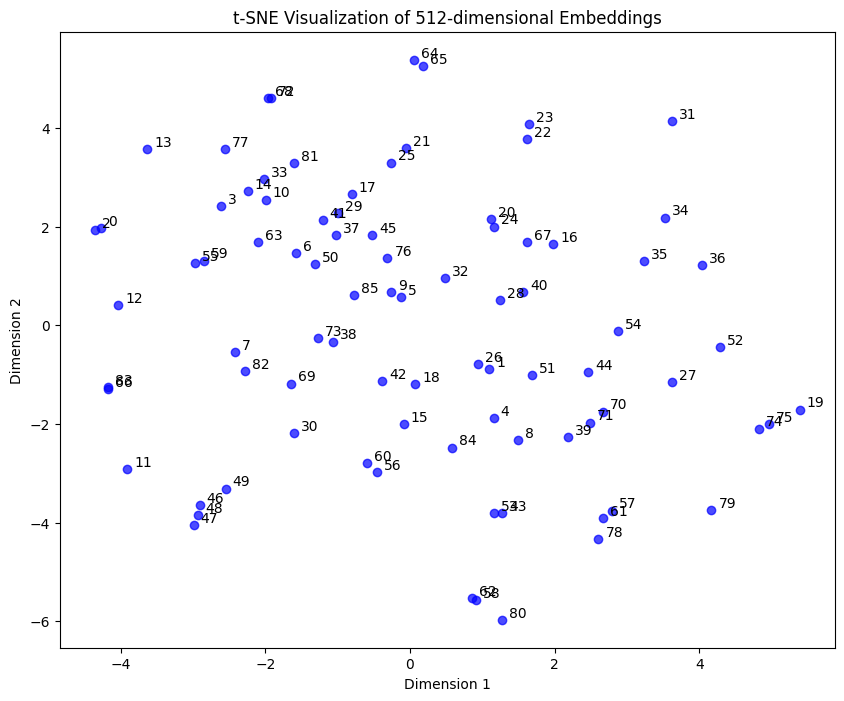

In [19]:
visualize_embeddings(embeddings_2d[:-1])

Também localizaremos onde nossa **<span style="color: red">pergunta</span>** está nesse espaço vetorial.

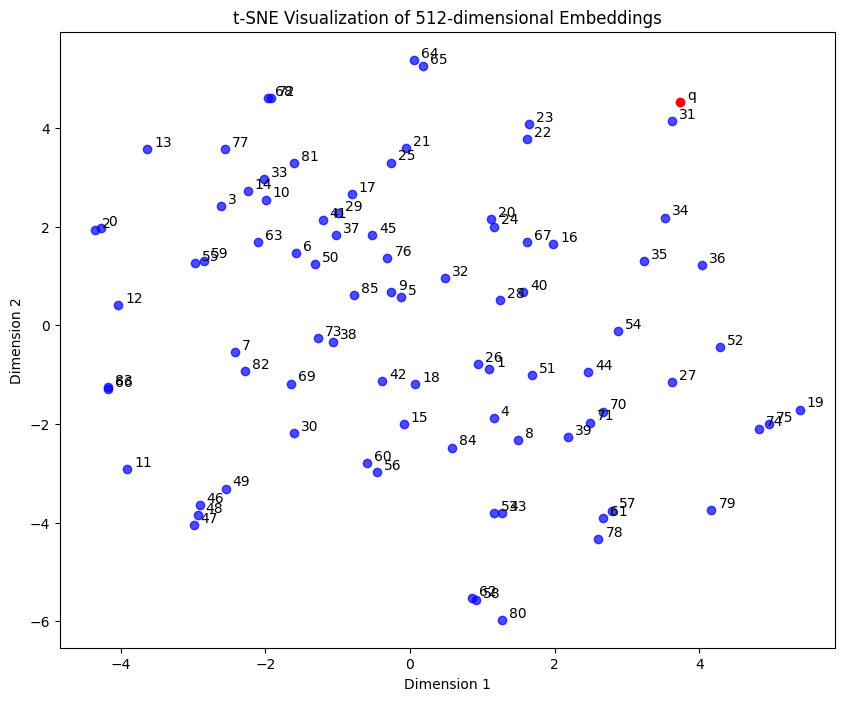

In [20]:
visualize_embeddings(embeddings_2d, True)

Em seguida, precisamos encontrar os "chunks" de texto que estão semanticamente mais próximos da nossa pergunta. Estes são os pedaços de texto que têm mais probabilidade de conter as respostas para a nossa pergunta.

Existem várias abordagens para alcançar isso, e usaremos a **Distância Euclidiana** para medir a similaridade/proximidade dos pontos de dados.

Para fazer isso, usaremos o algoritmo **Nearest Neighbors** e encontraremos os principais `k` pontos de dados que estão mais próximos da nossa pergunta. Em nosso exemplo, vamos recuperar os 5 principais pontos de dados por padrão.

In [21]:
nn_2d = NearestNeighbors(n_neighbors=5)
nn_2d.fit(embeddings_2d[:-1])

NearestNeighbors()

In [22]:
neighbors = nn_2d.kneighbors(embeddings_2d[-1].reshape(1, -1), return_distance=False)
neighbors

array([[31, 23, 22, 34, 35]])

Vamos agora plotar os pontos mais próximos como **<span style="color: purple">roxo</span>**.

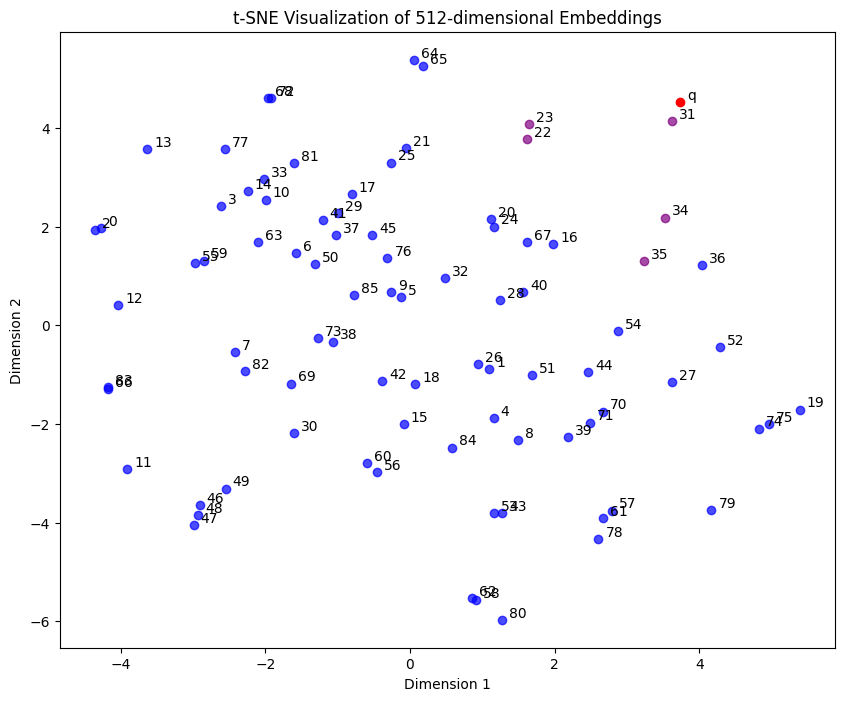

In [23]:
visualize_embeddings(embeddings_2d, True, neighbors)

## Busca Semântica

Como o t-SNE é um algoritmo não linear e perdemos alguma informação durante esse processo, não usaremos os vetores bidimensionais - esses foram usados apenas para fins de visualização.

Vamos repetir o mesmo processo acima, mas com os vetores completos de 512 dimensões.

Vamos ajustar nosso algoritmo Nearest Neighbors novamente, usando os embeddings de tamanho completo.

In [24]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(embeddings)

NearestNeighbors()

Vamos mais uma vez converter nossa pergunta em Embeddings.

In [25]:
emb_question = emb_model([question])
print(emb_question.shape)

(1, 512)


E, finalmente, encontrar os "chunks" de texto que estão mais próximos da nossa pergunta.

In [26]:
neighbors = nn.kneighbors(emb_question, return_distance=False)
neighbors

array([[31, 83,  3, 63, 66]])

Desta forma, temos os "**top 5** chunks" de texto que têm mais probabilidade de responder à nossa pergunta.

In [27]:
topn_chunks = [chunks[i] for i in neighbors.tolist()[0]]

## Construção do Prompt

Agora é hora de construir nosso prompt.

Lembre-se de que precisamos passar nosso contexto para ele.

Vamos iterar sobre nossos melhores "chunks" e adicioná-los ao prompt.

Por fim, forneceremos instruções ao nosso modelo, faremos nossa pergunta e receberemos nossa resposta.

In [28]:
def build_prompt(question):
    prompt = ""
    prompt += 'Dado o contexto:\n'
    
    for c in topn_chunks:
        prompt += c + '\n\n'
    
    # prompt += "Instructions: Compose a comprehensive reply to the query using the search results given. "\
    #         "Cite each reference using [Page Number] notation (every result has this number at the beginning). "\
    #         "Citation should be done at the end of each sentence. If the search results mention multiple subjects "\
    #         "with the same name, create separate answers for each. Only include information found in the results and "\
    #         "don't add any additional information. Make sure the answer is correct and don't output false content. "\
    #         "If the text does not relate to the query, simply state 'Found Nothing'. Ignore outlier "\
    #         "search results which has nothing to do with the question. Only answer what is asked. The "\
    #         "answer should be short and concise." 
    
    prompt += f"\n\n\n{question}"
    
    return prompt

In [29]:
prompt = build_prompt(question)
print(prompt)

Dado o contexto:
[Page no. 23] "transporte público e estacionamento serão reembolsadas, desde que sejam razoáveis e necessárias para os negócios. b. Acomodações  • Despesas com hospedagem serão reembolsadas com base nas tarifas corporativas negociadas pela empresa. • Os funcionários devem escolher acomodações que ofereçam conforto e segurança a um custo razoável. c. Alimentação • Despesas com alimentação durante viagens a negócios serão reembolsadas até os limites estabelecidos pela empresa. • O limite de valor para reembolso de um jantar pago para um cliente é de 300 reais. d. Outras Despesas • Despesas adicionais, como tarifas de internet, telefonemas de negócios e taxas de serviço, serão reembolsadas desde que sejam justificáveis e diretamente relacionadas às atividades de negócios. 6. Limites e Restrições • O limite máximo para reembolso de um jantar pago para um cliente é de 300 reais. • Despesas pessoais, como entretenimento, compras não relacionadas a negócios e uso de minibar, 

# Inferência com RAG

Para concluir nossa aplicação, tudo o que precisamos fazer agora é enviar nosso prompt ao nosso modelo e receber sua resposta com base no conteúdo que fornecemos.

In [32]:
print(get_completion(prompt))

O limite de valor para reembolso de um jantar pago para um cliente é de 300 reais.
